# SSY340 Project - Trajectory Estimation LSTM

### Fill in group number and member names:

In [26]:
NAME1 = "Bingcheng Chen" 
NAME2 = "Arvin Rokni"
GROUP = "Project groups 64"

## 1. Loading the data

In [27]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import os
import dataloader
import model_LSTM_attention
import utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## 2. Pre-processing

In [28]:
# defining model save location
save_location = "./LSTM_Attention_models"
# defining dataset locations
dataset_folder = "./datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# length of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12


train_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                             gt, horizon, delim="\t", train=True)
val_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                           gt, horizon, delim="\t", train=False)
# test_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

In [29]:
val_dataset[10]

{'src': tensor([[ 4.9693e+00,  8.3395e+00,  0.0000e+00,  0.0000e+00],
         [ 5.1330e+00,  8.3350e+00,  1.6374e-01, -4.5338e-03],
         [ 5.2968e+00,  8.3307e+00,  1.6374e-01, -4.2963e-03],
         [ 5.3915e+00,  8.3490e+00,  9.4709e-02,  1.8377e-02],
         [ 5.4565e+00,  8.3774e+00,  6.5034e-02,  2.8400e-02],
         [ 5.5218e+00,  8.4058e+00,  6.5244e-02,  2.8400e-02],
         [ 5.5868e+00,  8.4342e+00,  6.5033e-02,  2.8400e-02],
         [ 5.5988e+00,  8.4497e+00,  1.1997e-02,  1.5512e-02]]),
 'trg': tensor([[ 5.5575e+00,  8.4521e+00, -4.1251e-02,  2.3870e-03],
         [ 5.5163e+00,  8.4548e+00, -4.1251e-02,  2.6255e-03],
         [ 5.4750e+00,  8.4571e+00, -4.1251e-02,  2.3861e-03],
         [ 5.4340e+00,  8.4595e+00, -4.1041e-02,  2.3870e-03],
         [ 5.3927e+00,  8.4622e+00, -4.1251e-02,  2.6245e-03],
         [ 5.3515e+00,  8.4645e+00, -4.1251e-02,  2.3870e-03],
         [ 5.3102e+00,  8.4669e+00, -4.1251e-02,  2.3861e-03],
         [ 5.2690e+00,  8.4696e+00, -4.

In [30]:
val_dataset[10]['src'].shape

torch.Size([8, 4])

## 3. Data loaders

In [31]:
# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = DataLoader(train_dataset, batch_size,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)

## 4. Training

#### 4.1 create a model

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LSTM_attn_model = model_LSTM_attention.LSTM_Dual_Attention(
        input_size = 2, input_seq_len = 8, hidden_size = 128, num_layers = 1, output_size = 2, output_seq_len = 12, embedding_size = 16, num_heads = 1).to(device)

In [33]:
LSTM_attn_model

LSTM_Dual_Attention(
  (encoder): Encoder(
    (encoder_embedding): Embeddings(
      (linear_embd): Linear(in_features=2, out_features=16, bias=True)
    )
    (encoder_attn): MultiHeadAttention(
      (W_q): Linear(in_features=16, out_features=16, bias=True)
      (W_k): Linear(in_features=16, out_features=16, bias=True)
      (W_v): Linear(in_features=16, out_features=16, bias=True)
      (W_o): Linear(in_features=16, out_features=16, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder_lstm): LSTM(
      (LSTM_first_layer): ModuleList(
        (0): LSTMCell(
          (W_hh): Linear(in_features=128, out_features=512, bias=True)
          (W_xh): Linear(in_features=16, out_features=512, bias=True)
        )
      )
      (LSTM_whole): ModuleList(
        (0): LSTMCell(
          (W_hh): Linear(in_features=128, out_features=512, bias=True)
          (W_xh): Linear(in_features=16, out_features=512, bias=True)
        )
      )
    )
  )
  (decoder): Decoder(
  

#### 4.2 The training loop

In [34]:
# number of epochs
epochs = 100

# metric variables
training_loss = []
validation_loss = []
val_mad = []
val_fad = []

# Define the MSE loss function
criterion = nn.MSELoss()

learning_rate = 0.001
# optimizer = torch.optim.SGD(LSTM_attn_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(LSTM_attn_model.parameters(), lr=learning_rate)
# optimizer = torch.optim.AdamW(LSTM_attn_model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

for epoch in tqdm(range(epochs)):
    # TRAINING MODE
    LSTM_attn_model.train()

    # training batch variables
    train_batch_loss = 0

    for idx, data in enumerate(train_loader):
        # getting encoder input data
        X = data['src'][:, :, 0:2].to(device)
        target = data['trg'][:, :, 0:2].to(device)

        # forward pass
        optimizer.zero_grad()
        # predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)
        predictions = LSTM_attn_model.forward(X)

        loss = criterion(predictions.view(X.size(0), -1),
                         target.contiguous().view(X.size(0), -1))
        train_batch_loss += loss.item()

        # updating weights
        loss.backward()
        optimizer.step()

    training_loss.append(train_batch_loss/len(train_loader))
    print("Epoch {}/{}....Training loss = {:.4f}".format(epoch +
                                                         1, epochs, training_loss[-1]))

    # validation loop
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            # EVALUATION MODE
            LSTM_attn_model.eval()

            # validation variables
            batch_val_loss = 0
            gt = []
            pr = []

            for id_b, data in enumerate(val_loader):
                # storing groung truth
                truth = data['trg'][:, :, 0:2].to(device)
                gt.append(data['trg'][:, :, 0:2])
                # input to encoder input
                val_input = data['src'][:, :, 0:2].to(device)
                # prediction till horizon lenght
                model_output = LSTM_attn_model.forward(val_input)
                pr.append(model_output.view(val_input.size(0), 12, -1).cpu())

                # calculating loss using pairwise distance of all predictions
                val_loss = criterion(model_output.view(val_input.size(
                    0), -1), truth.contiguous().view(val_input.size(0), -1))
                batch_val_loss += val_loss.item()

            validation_loss.append(batch_val_loss/len(val_loader))

            # calculating mad and fad evaluation metrics
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            mad, fad, _ = dataloader.distance_metrics(gt, pr)
            val_mad.append(mad)
            val_fad.append(fad)

            print("Epoch {}/{}....Validation mad = {:.4f}, Validation fad = {:.4f}".format(
                epoch+1, epochs, mad, fad))

    if (epoch+1)%10 == 0:
        # Saving model, loss and error log files
        torch.save({
            'model_state_dict': LSTM_attn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss': training_loss,
            'validation_loss': validation_loss,
            'val_mad': val_mad,
            'val_fad': val_fad,
            'learning_rate': learning_rate
        }, os.path.join(save_location, 'LSTM_Attn_epoch{}.pth'.format(epoch+1)))


  1%|██                                                                                                                                                                                                          | 1/100 [00:11<19:20, 11.72s/it]

Epoch 1/100....Training loss = 5.7924


  2%|████                                                                                                                                                                                                        | 2/100 [00:23<19:12, 11.76s/it]

Epoch 2/100....Training loss = 2.2320


  3%|██████                                                                                                                                                                                                      | 3/100 [00:35<18:55, 11.71s/it]

Epoch 3/100....Training loss = 1.8271


  4%|████████▏                                                                                                                                                                                                   | 4/100 [00:46<18:44, 11.72s/it]

Epoch 4/100....Training loss = 1.5680
Epoch 5/100....Training loss = 1.4693


  5%|██████████▏                                                                                                                                                                                                 | 5/100 [00:59<19:10, 12.11s/it]

Epoch 5/100....Validation mad = 1.4909, Validation fad = 2.3038


  6%|████████████▏                                                                                                                                                                                               | 6/100 [01:11<18:53, 12.06s/it]

Epoch 6/100....Training loss = 1.3696


  7%|██████████████▎                                                                                                                                                                                             | 7/100 [01:23<18:31, 11.95s/it]

Epoch 7/100....Training loss = 1.2723


  8%|████████████████▎                                                                                                                                                                                           | 8/100 [01:35<18:15, 11.91s/it]

Epoch 8/100....Training loss = 1.2176


  9%|██████████████████▎                                                                                                                                                                                         | 9/100 [01:46<17:58, 11.86s/it]

Epoch 9/100....Training loss = 1.1845
Epoch 10/100....Training loss = 1.1525


 10%|████████████████████▎                                                                                                                                                                                      | 10/100 [01:59<18:11, 12.13s/it]

Epoch 10/100....Validation mad = 1.3507, Validation fad = 1.9344


 11%|██████████████████████▎                                                                                                                                                                                    | 11/100 [02:11<17:57, 12.11s/it]

Epoch 11/100....Training loss = 1.1266


 12%|████████████████████████▎                                                                                                                                                                                  | 12/100 [02:23<17:35, 11.99s/it]

Epoch 12/100....Training loss = 1.1145


 13%|██████████████████████████▍                                                                                                                                                                                | 13/100 [02:35<17:17, 11.93s/it]

Epoch 13/100....Training loss = 1.1159


 14%|████████████████████████████▍                                                                                                                                                                              | 14/100 [02:46<16:58, 11.84s/it]

Epoch 14/100....Training loss = 1.0868
Epoch 15/100....Training loss = 1.0777


 15%|██████████████████████████████▍                                                                                                                                                                            | 15/100 [02:59<17:12, 12.14s/it]

Epoch 15/100....Validation mad = 1.1182, Validation fad = 1.8352


 16%|████████████████████████████████▍                                                                                                                                                                          | 16/100 [03:11<16:53, 12.07s/it]

Epoch 16/100....Training loss = 1.0534


 17%|██████████████████████████████████▌                                                                                                                                                                        | 17/100 [03:23<16:31, 11.95s/it]

Epoch 17/100....Training loss = 1.0659


 18%|████████████████████████████████████▌                                                                                                                                                                      | 18/100 [03:35<16:17, 11.92s/it]

Epoch 18/100....Training loss = 1.0340


 19%|██████████████████████████████████████▌                                                                                                                                                                    | 19/100 [03:46<16:00, 11.86s/it]

Epoch 19/100....Training loss = 1.0308
Epoch 20/100....Training loss = 1.0120


 20%|████████████████████████████████████████▌                                                                                                                                                                  | 20/100 [03:59<16:12, 12.16s/it]

Epoch 20/100....Validation mad = 1.0787, Validation fad = 1.7843


 21%|██████████████████████████████████████████▋                                                                                                                                                                | 21/100 [04:11<15:55, 12.10s/it]

Epoch 21/100....Training loss = 0.9921


 22%|████████████████████████████████████████████▋                                                                                                                                                              | 22/100 [04:23<15:34, 11.98s/it]

Epoch 22/100....Training loss = 0.9932


 23%|██████████████████████████████████████████████▋                                                                                                                                                            | 23/100 [04:35<15:18, 11.93s/it]

Epoch 23/100....Training loss = 0.9765


 24%|████████████████████████████████████████████████▋                                                                                                                                                          | 24/100 [04:46<15:00, 11.85s/it]

Epoch 24/100....Training loss = 0.9587
Epoch 25/100....Training loss = 0.9431


 25%|██████████████████████████████████████████████████▊                                                                                                                                                        | 25/100 [04:59<15:10, 12.14s/it]

Epoch 25/100....Validation mad = 1.1154, Validation fad = 1.8122


 26%|████████████████████████████████████████████████████▊                                                                                                                                                      | 26/100 [05:11<14:53, 12.08s/it]

Epoch 26/100....Training loss = 0.9338


 27%|██████████████████████████████████████████████████████▊                                                                                                                                                    | 27/100 [05:23<14:33, 11.97s/it]

Epoch 27/100....Training loss = 0.8864


 28%|████████████████████████████████████████████████████████▊                                                                                                                                                  | 28/100 [05:34<14:15, 11.88s/it]

Epoch 28/100....Training loss = 0.8519


 29%|██████████████████████████████████████████████████████████▊                                                                                                                                                | 29/100 [05:46<13:58, 11.81s/it]

Epoch 29/100....Training loss = 0.8350
Epoch 30/100....Training loss = 0.7872


 30%|████████████████████████████████████████████████████████████▉                                                                                                                                              | 30/100 [05:59<14:06, 12.10s/it]

Epoch 30/100....Validation mad = 0.9728, Validation fad = 1.6699


 31%|██████████████████████████████████████████████████████████████▉                                                                                                                                            | 31/100 [06:11<13:51, 12.05s/it]

Epoch 31/100....Training loss = 0.7685


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                          | 32/100 [06:23<13:35, 12.00s/it]

Epoch 32/100....Training loss = 0.7549


 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                        | 33/100 [06:35<13:19, 11.94s/it]

Epoch 33/100....Training loss = 0.7468


 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                      | 34/100 [06:46<13:04, 11.89s/it]

Epoch 34/100....Training loss = 0.7259
Epoch 35/100....Training loss = 0.7234


 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                    | 35/100 [06:59<13:09, 12.15s/it]

Epoch 35/100....Validation mad = 0.9474, Validation fad = 1.6162


 36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                  | 36/100 [07:11<12:55, 12.12s/it]

Epoch 36/100....Training loss = 0.7031


 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                                | 37/100 [07:23<12:35, 11.99s/it]

Epoch 37/100....Training loss = 0.7086


 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 38/100 [07:34<12:17, 11.90s/it]

Epoch 38/100....Training loss = 0.6869


 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 39/100 [07:46<12:03, 11.87s/it]

Epoch 39/100....Training loss = 0.6962
Epoch 40/100....Training loss = 0.6846


 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 40/100 [07:59<12:08, 12.14s/it]

Epoch 40/100....Validation mad = 1.0546, Validation fad = 1.7115


 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 41/100 [08:11<11:54, 12.10s/it]

Epoch 41/100....Training loss = 0.6832


 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 42/100 [08:23<11:36, 12.00s/it]

Epoch 42/100....Training loss = 0.6653


 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 43/100 [08:35<11:20, 11.94s/it]

Epoch 43/100....Training loss = 0.6576


 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 44/100 [08:46<11:04, 11.86s/it]

Epoch 44/100....Training loss = 0.6518
Epoch 45/100....Training loss = 0.6501


 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 45/100 [08:59<11:06, 12.12s/it]

Epoch 45/100....Validation mad = 0.8980, Validation fad = 1.4857


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 46/100 [09:11<10:53, 12.09s/it]

Epoch 46/100....Training loss = 0.6464


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 47/100 [09:23<10:34, 11.97s/it]

Epoch 47/100....Training loss = 0.6421


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 48/100 [09:35<10:19, 11.92s/it]

Epoch 48/100....Training loss = 0.6278


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 49/100 [09:46<10:03, 11.83s/it]

Epoch 49/100....Training loss = 0.6390
Epoch 50/100....Training loss = 0.6232


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 50/100 [09:59<10:04, 12.10s/it]

Epoch 50/100....Validation mad = 0.9813, Validation fad = 1.5517


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 51/100 [10:11<09:51, 12.07s/it]

Epoch 51/100....Training loss = 0.6183


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 52/100 [10:23<09:34, 11.98s/it]

Epoch 52/100....Training loss = 0.6138


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 53/100 [10:35<09:21, 11.95s/it]

Epoch 53/100....Training loss = 0.6173


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 54/100 [10:46<09:05, 11.86s/it]

Epoch 54/100....Training loss = 0.6043
Epoch 55/100....Training loss = 0.6186


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 55/100 [10:59<09:04, 12.09s/it]

Epoch 55/100....Validation mad = 0.9434, Validation fad = 1.5202


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 56/100 [11:11<08:49, 12.04s/it]

Epoch 56/100....Training loss = 0.6112


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 57/100 [11:22<08:33, 11.94s/it]

Epoch 57/100....Training loss = 0.6096


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 58/100 [11:34<08:18, 11.87s/it]

Epoch 58/100....Training loss = 0.5987


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 59/100 [11:46<08:05, 11.85s/it]

Epoch 59/100....Training loss = 0.5974
Epoch 60/100....Training loss = 0.6085


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 60/100 [11:59<08:04, 12.12s/it]

Epoch 60/100....Validation mad = 0.9111, Validation fad = 1.4829


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 61/100 [12:11<07:55, 12.19s/it]

Epoch 61/100....Training loss = 0.5880


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 62/100 [12:23<07:37, 12.05s/it]

Epoch 62/100....Training loss = 0.5920


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 63/100 [12:34<07:21, 11.93s/it]

Epoch 63/100....Training loss = 0.5734


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 64/100 [12:46<07:07, 11.87s/it]

Epoch 64/100....Training loss = 0.5794
Epoch 65/100....Training loss = 0.5803


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 65/100 [12:59<07:04, 12.12s/it]

Epoch 65/100....Validation mad = 0.8866, Validation fad = 1.4671


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 66/100 [13:11<06:52, 12.12s/it]

Epoch 66/100....Training loss = 0.5648


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 67/100 [13:23<06:36, 12.01s/it]

Epoch 67/100....Training loss = 0.5772


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 68/100 [13:34<06:19, 11.86s/it]

Epoch 68/100....Training loss = 0.5729


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 69/100 [13:46<06:06, 11.83s/it]

Epoch 69/100....Training loss = 0.5707
Epoch 70/100....Training loss = 0.5731


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 70/100 [13:58<06:00, 12.02s/it]

Epoch 70/100....Validation mad = 0.8995, Validation fad = 1.4717


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 71/100 [14:10<05:45, 11.91s/it]

Epoch 71/100....Training loss = 0.5637


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 72/100 [14:22<05:30, 11.79s/it]

Epoch 72/100....Training loss = 0.5574


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 73/100 [14:33<05:15, 11.69s/it]

Epoch 73/100....Training loss = 0.5545


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 74/100 [14:45<05:02, 11.64s/it]

Epoch 74/100....Training loss = 0.5618
Epoch 75/100....Training loss = 0.5518


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 75/100 [14:57<04:57, 11.88s/it]

Epoch 75/100....Validation mad = 0.8866, Validation fad = 1.4900


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 76/100 [15:09<04:43, 11.82s/it]

Epoch 76/100....Training loss = 0.5502


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 77/100 [15:20<04:29, 11.72s/it]

Epoch 77/100....Training loss = 0.5454


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 78/100 [15:32<04:15, 11.63s/it]

Epoch 78/100....Training loss = 0.5502


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 79/100 [15:43<04:04, 11.63s/it]

Epoch 79/100....Training loss = 0.5412
Epoch 80/100....Training loss = 0.5486


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 80/100 [15:56<03:58, 11.91s/it]

Epoch 80/100....Validation mad = 0.8505, Validation fad = 1.4574


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 81/100 [16:07<03:43, 11.78s/it]

Epoch 81/100....Training loss = 0.5434


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 82/100 [16:19<03:31, 11.76s/it]

Epoch 82/100....Training loss = 0.5335


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 83/100 [16:30<03:18, 11.66s/it]

Epoch 83/100....Training loss = 0.5484


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 84/100 [16:42<03:06, 11.63s/it]

Epoch 84/100....Training loss = 0.5616
Epoch 85/100....Training loss = 0.5475


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 85/100 [16:55<02:58, 11.88s/it]

Epoch 85/100....Validation mad = 0.8332, Validation fad = 1.4025


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 86/100 [17:06<02:44, 11.78s/it]

Epoch 86/100....Training loss = 0.5328


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 87/100 [17:18<02:32, 11.74s/it]

Epoch 87/100....Training loss = 0.5259


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 88/100 [17:29<02:19, 11.64s/it]

Epoch 88/100....Training loss = 0.5353


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 89/100 [17:41<02:08, 11.64s/it]

Epoch 89/100....Training loss = 0.5445
Epoch 90/100....Training loss = 0.5234


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 90/100 [17:53<01:59, 11.95s/it]

Epoch 90/100....Validation mad = 0.9268, Validation fad = 1.5997


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 91/100 [18:05<01:46, 11.78s/it]

Epoch 91/100....Training loss = 0.5232


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 92/100 [18:17<01:34, 11.76s/it]

Epoch 92/100....Training loss = 0.5158


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 93/100 [18:28<01:21, 11.67s/it]

Epoch 93/100....Training loss = 0.5258


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 94/100 [18:39<01:09, 11.59s/it]

Epoch 94/100....Training loss = 0.5216
Epoch 95/100....Training loss = 0.5225


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 95/100 [18:52<00:59, 11.89s/it]

Epoch 95/100....Validation mad = 0.8973, Validation fad = 1.4994


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 96/100 [19:03<00:46, 11.73s/it]

Epoch 96/100....Training loss = 0.5064


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 97/100 [19:15<00:35, 11.78s/it]

Epoch 97/100....Training loss = 0.5173


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 98/100 [19:27<00:23, 11.68s/it]

Epoch 98/100....Training loss = 0.5146


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/100 [19:38<00:11, 11.63s/it]

Epoch 99/100....Training loss = 0.5032
Epoch 100/100....Training loss = 0.5117


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [19:51<00:00, 11.91s/it]

Epoch 100/100....Validation mad = 0.8482, Validation fad = 1.4695


## 5. Visualisation

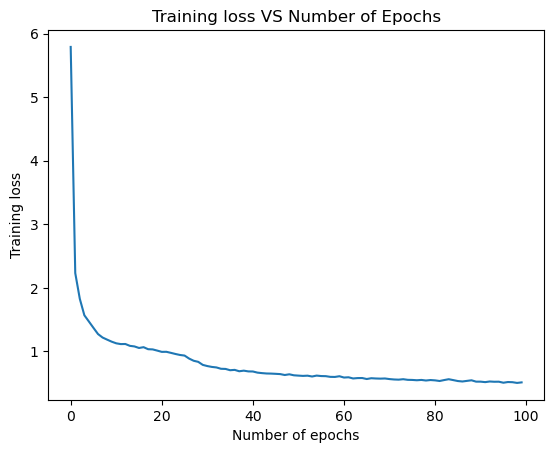

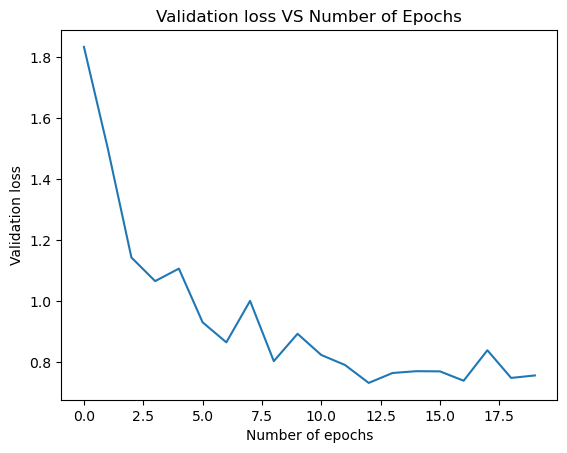

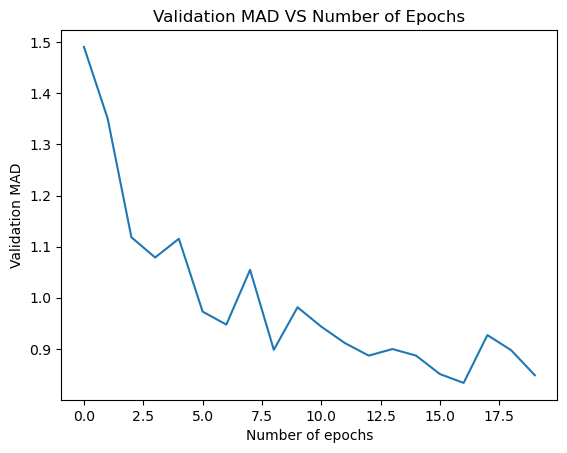

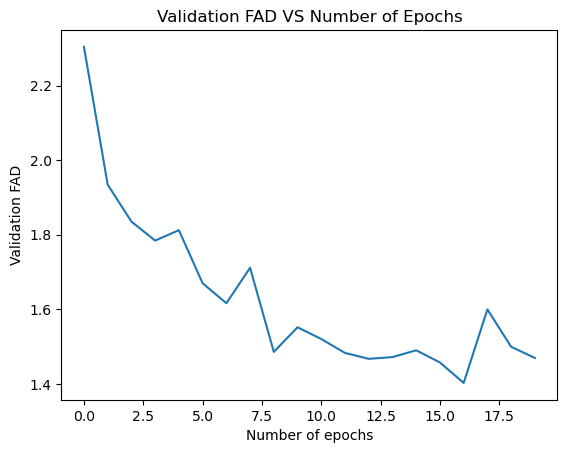

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_file = torch.load(os.path.join(
    save_location, 'LSTM_Attn_epoch100.pth'), map_location=torch.device(device))

# creating model and loading weights
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout = 0.1

# model_loaded = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size,
#                              num_heads, ff_hidden_size, n, dropout=0.1)

model_loaded = model_LSTM_attention.LSTM_Dual_Attention(
        input_size = 2, input_seq_len = 8, hidden_size = 128, num_layers = 1, output_size = 2, output_seq_len = 12, embedding_size = 16, num_heads = 1)


model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(loaded_file['model_state_dict'])

# loading training metric variables
training_loss = loaded_file['training_loss']
validation_loss = loaded_file['validation_loss']
val_mad = loaded_file['val_mad']
val_fad = loaded_file['val_fad']
learning_rate = loaded_file['learning_rate']

# plotting training loss
plt.figure()
plt.plot(training_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Training loss VS Number of Epochs")

# plotting validation loss
plt.figure()
plt.plot(validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss VS Number of Epochs")

# plotting learning rate for model
# plt.figure()
# plt.plot(learning_rate)
# plt.xlabel("Number of epochs")
# plt.ylabel("learning_rate")
# plt.title("Learning_rate VS Number of Epochs")

# plotting MAD
plt.figure()
plt.plot(val_mad)
plt.xlabel("Number of epochs")
plt.ylabel("Validation MAD")
plt.title("Validation MAD VS Number of Epochs")

# plotting FAD
plt.figure()
plt.plot(val_fad)
plt.xlabel("Number of epochs")
plt.ylabel("Validation FAD")
plt.title("Validation FAD VS Number of Epochs")

plt.show()

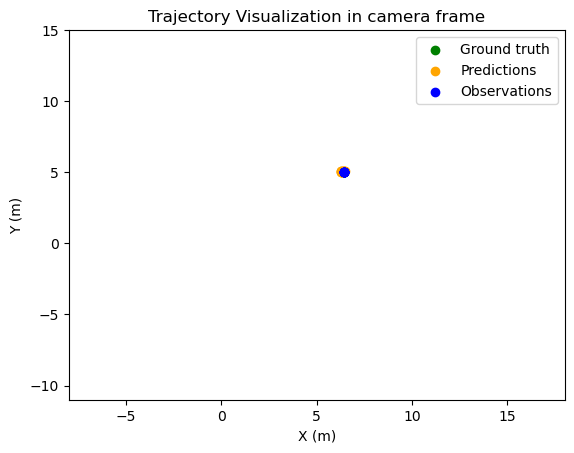

In [40]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_loaded.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        truth = data['trg'][:, :, 0:2].to(device)
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = data['src'][:, :, 0:2].to(device)

        # prediction till horizon lenght
        model_output = model_loaded.forward(val_input)
        pr.append(model_output.view(val_input.size(0), 12, -1).cpu())

        # calculating loss using pairwise distance of all predictions
        val_loss = criterion(model_output.view(val_input.size(0), -1), truth.contiguous().view(val_input.size(0), -1))
        batch_val_loss += val_loss.item()

        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt = np.concatenate(gt, 0)
    pr = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt, pr)
    val_mad.append(mad)
    val_fad.append(fad)

# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

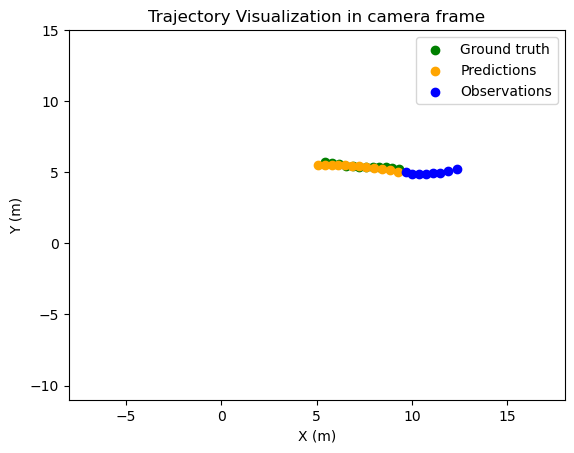

In [42]:
# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
# plt.savefig("traj_{}".format(idx))

plt.show()

## 6. Evaluation on test set